In [25]:
%load_ext autoreload
%autoreload 2
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from pathlib import Path

MPL_CUSTOM = {
    'font.family': 'serif',
    'mathtext.fontset': 'cm',
    'figure.dpi': 120,
    'figure.figsize': (4, 3.5),
    'figure.facecolor': 'white',
    'xtick.top': True,
    'xtick.direction': 'in',
    'xtick.minor.visible': True,
    'ytick.right': True,
    'ytick.direction': 'in',
    'ytick.minor.visible': True,
}

for k, v in MPL_CUSTOM.items():
    mpl.rcParams[k] = v

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
project_dir = Path(os.environ['CONDA_PREFIX']).parent.absolute()
current_dir = project_dir / 'scratch/ana/result/sbtCharge'

In [27]:
# files = sorted(list(current_dir.glob('*.txt')))
files = sorted([current_dir / f'data{idx}.txt' for idx in range(1160, 1330)])
df_list = [pd.read_csv(str(f), sep=r'\s+', header=None, names=['iEvt', 'sbt1', 'sbt2']) for f in files]

df_sbt1_list = [
    pd.DataFrame({'x' : df['iEvt'], 'y' : df['sbt1']}) for df in df_list
]
df_sbt2_list = [
    pd.DataFrame({'x' : df['iEvt'], 'y' : df['sbt2']}) for df in df_list
]


In [28]:
total_events = 0
for i in range(len(df_sbt1_list)):
    df_sbt1_list[i]['x'] += total_events
    df_sbt2_list[i]['x'] += total_events
    total_events += len(df_sbt1_list[i])

df_sbt1_list = {idx + 1036 : df for idx, df in enumerate(df_sbt1_list)}
df_sbt2_list = {idx + 1036 : df for idx, df in enumerate(df_sbt2_list)}

In [29]:
def rebin(df, bins, range_):
    hist, edges = np.histogram(
        df.x.values, 
        weights=df.y.values,
        bins=bins, 
        range=range_
    )
    entries, _ = np.histogram(
        df.x.values,
        bins=bins, 
        range=range_
    )

    return pd.DataFrame({
        'x' : 0.5 * (edges[:-1] + edges[1:]),
        'y' : np.divide(hist, entries, out=np.zeros_like(hist), where=entries!=0)
    })

In [30]:
binning = 1000
df_sbt1_rebin = {}
df_sbt2_rebin = {}

total_events = 0
for idx, df in df_sbt1_list.items():
    if len(df) == 0:
        continue
    df = df.copy()
    rangeh = np.ceil(((df.x.values[-1] + 1)) / 10000) * 10000
    rangel = np.floor((df.x.values[0] + total_events)  / 10000) * 10000
    nbins = int((rangeh - rangel) / binning)
    print(idx, rangel, rangeh, nbins)

    df_sbt1_rebin[idx] = rebin(df, nbins, (rangel, rangeh))
    df_sbt2_rebin[idx] = rebin(df_sbt2_list[idx], nbins, (rangel, rangeh))


1036 0.0 40000.0 40
1037 30000.0 80000.0 50
1038 70000.0 100000.0 30
1039 90000.0 140000.0 50
1040 130000.0 170000.0 40
1041 160000.0 210000.0 50
1042 200000.0 250000.0 50
1043 240000.0 280000.0 40
1044 270000.0 320000.0 50
1045 310000.0 350000.0 40
1046 340000.0 390000.0 50
1047 380000.0 420000.0 40
1048 410000.0 450000.0 40
1049 440000.0 460000.0 20
1050 450000.0 490000.0 40
1051 480000.0 530000.0 50
1052 520000.0 560000.0 40
1053 550000.0 560000.0 10
1054 550000.0 600000.0 50
1055 590000.0 640000.0 50
1056 630000.0 660000.0 30
1057 650000.0 720000.0 70
1058 710000.0 790000.0 80
1059 780000.0 860000.0 80
1060 850000.0 920000.0 70
1061 910000.0 980000.0 70
1062 970000.0 1020000.0 50
1064 1010000.0 1030000.0 20
1065 1020000.0 1100000.0 80
1066 1090000.0 1160000.0 70
1067 1150000.0 1220000.0 70
1068 1210000.0 1280000.0 70
1069 1270000.0 1280000.0 10
1070 1270000.0 1290000.0 20
1071 1280000.0 1360000.0 80
1072 1350000.0 1420000.0 70
1073 1410000.0 1490000.0 80
1074 1480000.0 1560000.0 80

In [31]:
cmap = plt.get_cmap('rainbow')
colors = [cmap(i) for i in np.linspace(0, 1, len(df_sbt1_rebin))]

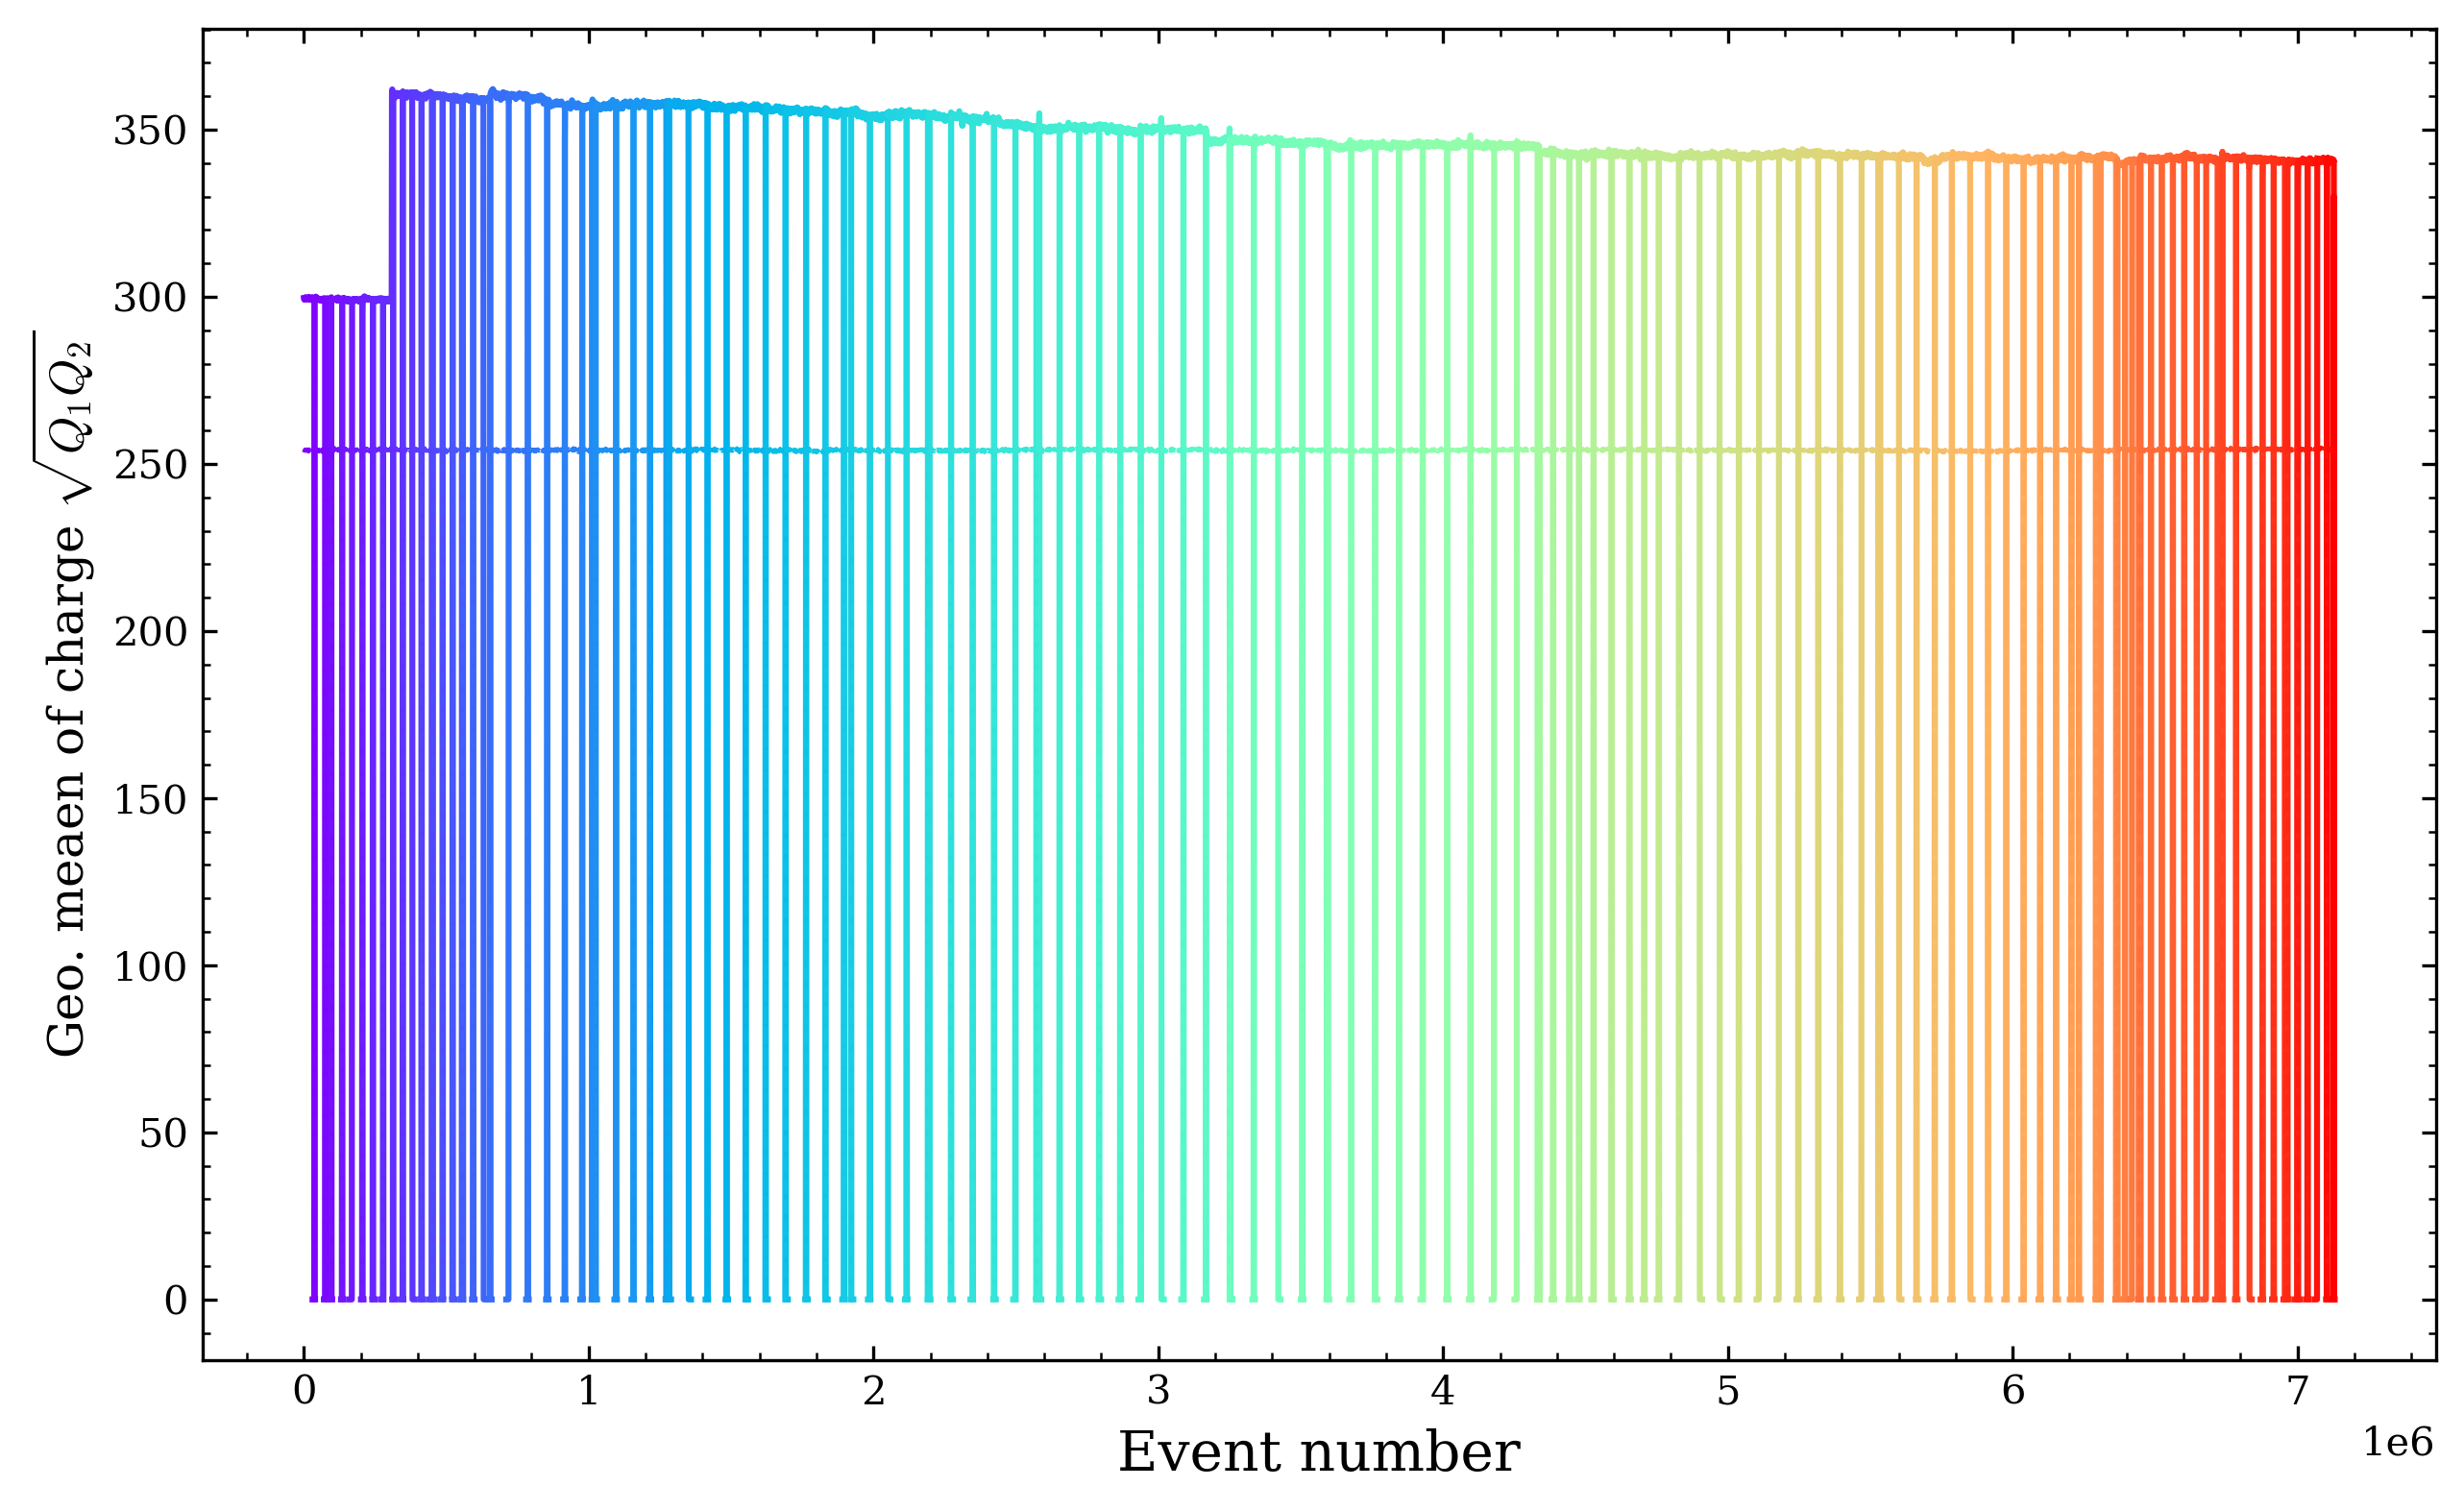

In [32]:
fig, ax = plt.subplots(
    figsize=(10, 6),
    facecolor='white',
    dpi=300,
)

for idx, irun in enumerate(df_sbt1_rebin.keys()):
    # print(len(df_sbt1_rebin[irun]))
    # print(df_sbt1_rebin[irun].x.values[-1])
    # if irun != 1045:
    #     continue
    ax.plot(
        df_sbt1_rebin[irun].x.values,
        df_sbt1_rebin[irun].y.values,
        color=colors[idx],
        # label=f'Run {idx}',
    )

    ax.plot(
        df_sbt2_rebin[irun].x.values,
        df_sbt2_rebin[irun].y.values,
        color=colors[idx],
        linestyle='--',
        linewidth=1,
        zorder=10
        # label=f'Run {idx}',
    )

# ax.set_xlim(-10000, 760000)
# ax.set_ylim(350,500)
ax.set_xlabel('Event number', fontsize=14)
ax.set_ylabel(r'Geo. meaen of charge $\sqrt{Q_1Q_2}$', fontsize=12)

# ax.annotate(
#     'SBT 1 (thin)',
#     xy=(0.1, 0.9),
#     xycoords='axes fraction',
#     fontsize=12,
#     ha='left',
#     va='top',
#     bbox=dict(
#         boxstyle='round',
#         edgecolor='black',
#         facecolor='white',
#         alpha=0.1
#     )
# )

# ax.annotate(
#     'SBT 2 (thick)',
#     xy=(0.1, 0.3),
#     xycoords='axes fraction',
#     fontsize=12,
#     ha='left',
#     va='top',
#     bbox=dict(
#         boxstyle='round',
#         edgecolor='black',
#         facecolor='white',
#         alpha=0.1
#     )
# )

plt.show()